In [191]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean
import pickle
import statistics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from numpy import absolute

In [2]:
city = 'Bhopal'
month = 'July'
PATH = f'./../Item_wise_data/{city}/'
# PATH = './../'


In [3]:
# exclude non baking items
df = pd.read_csv(PATH+f'{month}.csv')
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])
# df

/tmp/ipykernel_14922/70406848.py:2: DtypeWarning: Columns (5,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH+f'{month}.csv')


In [4]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Driver_Shift', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)


(156415, 29)
(156415, 9)


In [5]:
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = round(df['prep_time']/np.timedelta64(1, 's')).astype(int) + 7*60
print(df.shape)
df.head()

(156415, 10)


,Location_Code,Order_Date,Order_Number,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,461
158804,DPI66154,2022-07-01 00:00:00,1,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,605
33904,DPI66576,2022-07-01 00:00:00,2,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,508
69467,DPI66576,2022-07-01 00:00:00,2,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,509
53156,DPI66449,2022-07-01 00:00:00,2,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,505


In [8]:
isThresholdForPreparationTime = True
thresholdForPreparationTime = 30 # minutes for preparation time (threshold)
if (isThresholdForPreparationTime):
    df = df.loc[df['prep_time'] <= thresholdForPreparationTime*60]
print(df.shape)
df.head()

(156385, 10)


,Location_Code,Order_Date,Order_Number,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
92935,DPI66576,2022-07-01 00:00:00,1,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,461
158804,DPI66154,2022-07-01 00:00:00,1,2022-07-01 11:06:53.140,2022-07-01 11:09:58.387,PIZ5106,Chicken Sausage,1.0,2022-07-01 11:24:46.000,605
33904,DPI66576,2022-07-01 00:00:00,2,2022-07-01 11:12:01.983,2022-07-01 11:13:30.210,PIZ0121,VG2-1Mexican Green,1.0,2022-07-01 11:26:48.840,508
69467,DPI66576,2022-07-01 00:00:00,2,2022-07-01 11:12:01.983,2022-07-01 11:13:30.697,PIZ0120,VG2-1Peppy Paneer,1.0,2022-07-01 11:26:48.840,509
53156,DPI66449,2022-07-01 00:00:00,2,2022-07-01 11:12:33.490,2022-07-01 11:13:58.503,PIZ0130,_PM39-Pizza Mania Golden Corn,1.0,2022-07-01 11:32:00.000,505


In [9]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = df['Location_Code'].unique()
# allMenuCodes, allStoreIds
len(allMenuCodes)
len(allStoreIds)

12

In [10]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = df.loc[df['Location_Code'] == storeId]

In [11]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [12]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if(stores[i] == storeId):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        return [item['Location_Code']]

In [13]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

['DPI66576']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
# Feature 2: Item Type
def getOneHotEncodedItemList(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodedItemList(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if (items[i] == item):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, clubCategoryWise=False):
    return getOneHotEncodedItemList(item['Menu_Code'], allMenuCodes, clubCategoryWise)

In [15]:
print(getItemType(sampleItem))
print(getItemType(sampleItem, True))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]


In [16]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    return getOneHotEncodingTimeSlot(timeslot)

In [17]:
def get_preparation_time(item):
    return item['prep_time']
# 	diff = item['Oven_Time'] - item['Kitchen_Display_Time']
# 	return diff.total_seconds() + 7*60

In [18]:
# Feature 4 : Count of all baking items of all orders received by the store in the last 20 minutes.

def countPastOrders(item, slotTime=30):
    storeId = item['Location_Code']
    df = restWiseDFs[storeId]
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=slotTime)
    return len(df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
          (df['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [19]:
d = datetime.strptime('2021-12-20 00:00:00', '%Y-%m-%d %H:%M:%S')


In [20]:
# TIME CONSUMING (4 m 14 seconds for Bhopal)
# Feature 5 : Avg prep time of the same item in the same store in last 60 minutes.

for storeId in restWiseDFs:
    avgPrepTime = restWiseDFs[storeId]['prep_time'].mean()    
    restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
    
    for index, item in restWiseDFs[storeId].iterrows():
        itemCode = item['Menu_Code']
        dtKitchenDisplay = item['Kitchen_Display_Time']
        
        lastTime = dtKitchenDisplay - timedelta(minutes=60)
        
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= lastTime) & \
                     (restWiseDFs[storeId]['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (restWiseDFs[storeId]['Menu_Code'] == itemCode)]
        if (len(df2.index) != 0):
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] = df2['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] =  avgPrepTime



/tmp/ipykernel_14922/2333041051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_14922/2333041051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_14922/2333041051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [21]:
def getPreviousPrepTime(item, timeslot = 60):
    if(timeslot == 60):
        return item['avg_kpt_in_last_one_hour']
    else:
        itemCode = item['Menu_Code']
        df = restWiseDFs[item['Location_Code']]
        
        dtKitchenDisplay = item['Kitchen_Display_Time']
        
        lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
        
        df2 = df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
                     (df['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (df['Menu_Code'] == itemCode)]
        if (len(df2.index) != 0):
            return df2['prep_time'].mean()
        else:
            return restWiseDFs[storeId]['prep_time'].mean()    

In [22]:
# Feature 6 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = restWiseDFs[item['Location_Code']]
    return len(d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]['Order_Number'].index)

In [23]:
sampleItem=None
for index, item in restWiseDFs[storeId].iterrows():
    sampleItem = item
    break

In [24]:
lengthQueue(sampleItem)

2

In [25]:
# global variables

clubItemsCategoryWise = False

splitMethod = 'random'
slotTimeForPastOrders = 20 # minutes

model = 'RF'
isOneHotEncodingRequired = True
isNormalizationRequired = True

In [26]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [27]:
save_object(restWiseDFs, f'restWiseDFsBeforeFeatureCreation{city}.pkl')

In [ ]:
totalFeatures = (len(allMenuCodes) +  # one hot encoded item type
                24 +  #one hot encoded timeslot of the day
                1 +  #count past orders
                1 + # average previous preparation time in last 1 hour
                1+1) # length of the current queue
feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_'+str(i+1))

In [ ]:
def isHeavyLoadDay(dt):
    if(dt.weekday() >= 5):
        return 1
    return 0

In [101]:
def updateFeatures(storeId, Xnp):
    restWiseDFs[storeId][feature_cols] = Xnp

In [102]:
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getItemType(item)
        features +=  getTimeSlotOfKitchenDisplayTime(item)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot = 60)]
        features += [lengthQueue(item), isHeavyLoadDay(item['Kitchen_Display_Time'])]
        X.append(features)
    
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)

In [177]:
totalFeatures

174

In [103]:
restWiseScalers = {}

# normalize feature values
for storeId in allStoreIds:
    X = restWiseDFs[storeId].loc[:, feature_cols]
    scaler = StandardScaler()
    if(isNormalizationRequired):
        scaler.fit(X)
        X_scaled = scaler.transform(X)
        X_scalednp = np.array(X_scaled)
        updateFeatures(storeId, X_scalednp)

In [104]:
save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')

In [105]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [106]:
# Time Consuming (training on first 14 days of July)
restWiseModels = {}

for storeId in allStoreIds:
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]
    
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()
    
    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)
    restWiseModels[storeId] = regressor
    
    
    X = restWiseDFs[storeId].loc[:, feature_cols]
    y = restWiseDFs[storeId].prep_time.values.tolist()
    predictions = regressor.predict(X)
    restWiseDFs[storeId]['predicted_prep_time'] = predictions
    
    a = getRMSE(y, predictions)
    print("RMSE score overall for store (30 days) "+storeId+" :  ", a)

RMSE score overall for store (30 days) DPI66576 :   65.15729502035599
RMSE score overall for store (30 days) DPI66154 :   65.30789304887728
RMSE score overall for store (30 days) DPI66449 :   89.33332714923527
RMSE score overall for store (30 days) DPI66313 :   29.780998189319234
RMSE score overall for store (30 days) DPI63827 :   63.79269188729977
RMSE score overall for store (30 days) DPI66653 :   81.70251422550501
RMSE score overall for store (30 days) DPI66221 :   77.70770919786365
RMSE score overall for store (30 days) DPI64196 :   50.30952209948981
RMSE score overall for store (30 days) DPI67072 :   104.91848702788876
RMSE score overall for store (30 days) DPI66373 :   65.21302722770896
RMSE score overall for store (30 days) DPI66153 :   63.66649538161317
RMSE score overall for store (30 days) DPI63919 :   89.33470660030562


In [107]:
save_object(restWiseDFs, f'restWiseDFsWithPredictions{city}.pkl')

In [108]:
save_object(restWiseModels, f'restWiseModels{city}.pkl')

In [122]:
def getPredictionHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime)]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.predicted_prep_time).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = ((df.prep_time - abs(df.prep_time - df.predicted_prep_time))/df.prep_time).values.tolist()
    meanAccuracy = statistics.mean(accuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [80]:
# def getBaselineHyperparamters(startDay, endDay):
#     df = pd.DataFrame()
#     firstTime = datetime(2022, 7, startDay)
#     lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
#     for storeId in allStoreIds:
#         df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
#           (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime)]
#         df = pd.concat([df, df2], ignore_index = True)
    
#     rmse = ((df.prep_time - df['prep_time'].mean()) ** 2).mean() ** .5
    
#     error = (abs(df.prep_time - df['prep_time'].mean())).values.tolist()
#     absError = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
#     meanAbsError = statistics.mean(error)
#     medianAbsError = statistics.median(error)
#     stdAbsError = statistics.stdev(error)
    
#     error = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
#     meanError = statistics.mean(error)
#     medianError = statistics.median(error)
#     stdError = statistics.stdev(error)
#     return rmse, meanAbsError, medianAbsError, stdAbsError, meanError, medianError, stdError

In [74]:
print("HELLO")

HELLO


In [81]:
getPredictionHyperparameters(1, 14)

(32.85109404636338, 17.588030358897278, 9.228583333333233, 27.746475542811286)

In [82]:
getBaselineHyperparamters(1, 14)

(112.09885934663545, 76.95348180234451, 63.77180891794785, 81.51327345688885)

In [123]:
rmseList = []
meanAbsErrorList = []
medianAbsErrorList = []
stdAbsErrorList = []
meanErrorList = []
medianErrorList = []
stdErrorList = []
meanAccuracyList = []
medianAccuracyList = []
stdAccuracyList = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getPredictionHyperparameters(i,i)
    rmseList.append(rmse)
    meanAbsErrorList.append(meanAbsError)
    medianAbsErrorList.append(medianAbsError)
    stdAbsErrorList.append(stdAbsError)
    meanErrorList.append(meanError)
    medianErrorList.append(medianError)
    stdErrorList.append(stdError)
    meanAccuracyList.append(meanAccuracy)
    medianAccuracyList.append(medianAccuracy)
    stdAccuracyList.append(stdAccuracy)

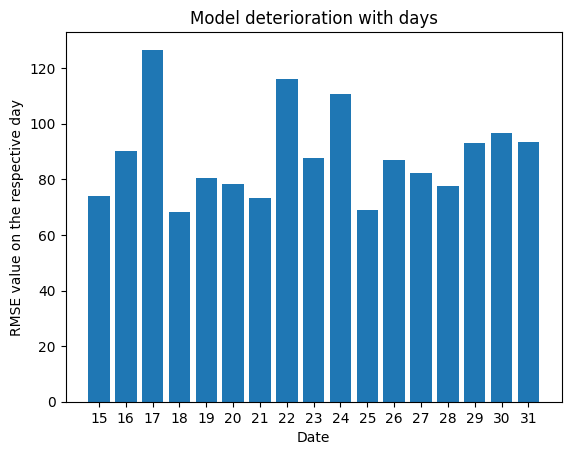

In [192]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Model deterioration with days")
plt.savefig(f'{city}_1.png')

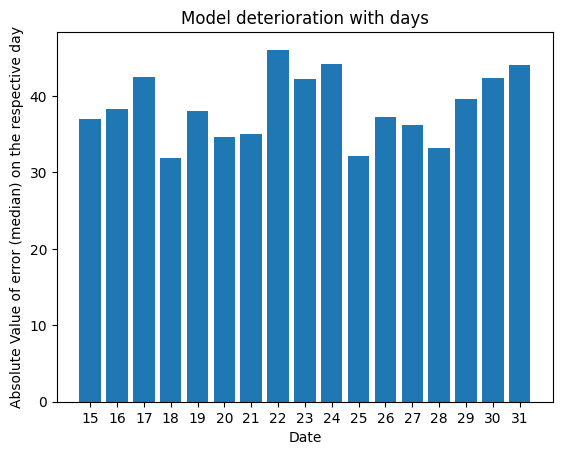

In [193]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Model deterioration with days")
plt.savefig(f'{city}_3.png')

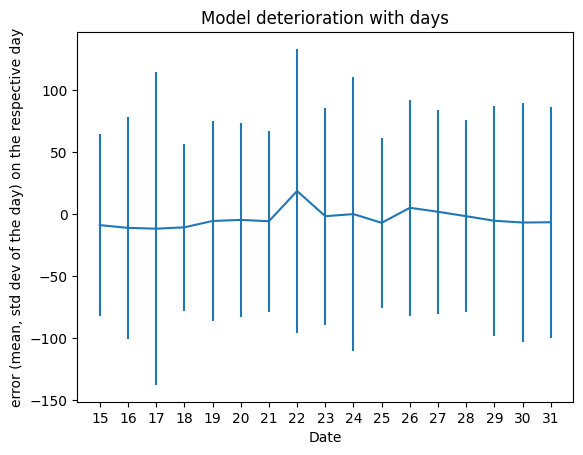

In [194]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorList, stdErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Model deterioration with days")
plt.savefig(f'{city}_4.png')

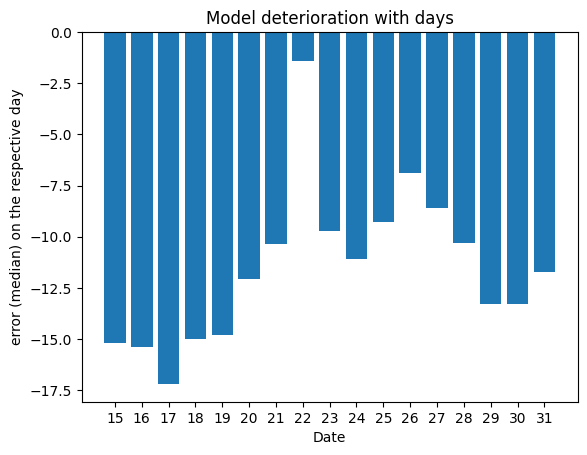

In [195]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Model deterioration with days")
plt.savefig(f'{city}_5.png')

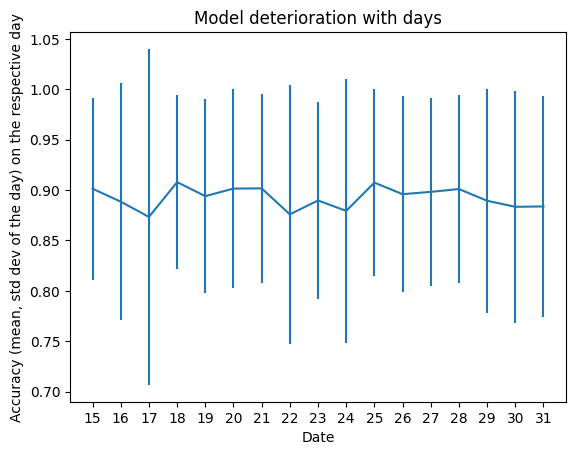

In [200]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyList, stdAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Model deterioration with days")
plt.savefig(f'{city}_6.png')



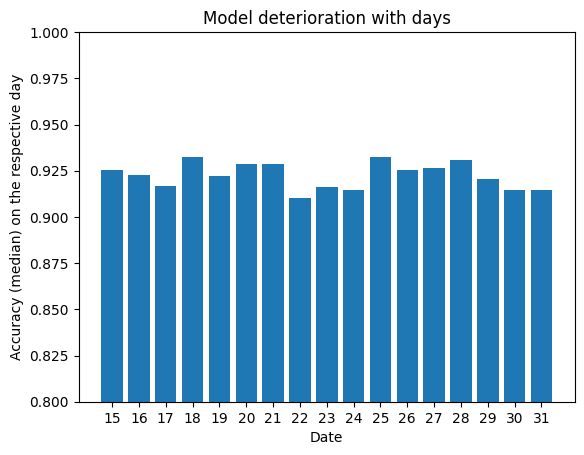

In [199]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.8, 1)
plt.bar(x, medianAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Model deterioration with days")
plt.savefig(f'{city}_7.png')


In [208]:
# baseline approach
# Hourwise avg 

weekdayHourWiseAvg = {}
weekendHourWiseAvg = {}
for store in allStoreIds:
    weekdayHourWiseAvg[store] = {}
    weekendHourWiseAvg[store] = {}
for i in range(1, 15):
    dt = datetime(2022, 7, i)
    for storeId in allStoreIds:
        df = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= dt) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < dt+timedelta(days=1))]
        for index, item in df.iterrows():
            ts = getTimeslot(item['Kitchen_Display_Time'])
            if(isHeavyLoadDay(item['Kitchen_Display_Time'])):
                if ts not in weekendHourWiseAvg[storeId]:
                    weekendHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekendHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekendHourWiseAvg[storeId][ts]['cnt'] += 1
            else:
                if ts not in weekdayHourWiseAvg[storeId]:
                    weekdayHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekdayHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekdayHourWiseAvg[storeId][ts]['cnt'] += 1

for storeId in allStoreIds:
    for ts in weekdayHourWiseAvg[storeId].keys():
        weekdayHourWiseAvg[storeId][ts]['val'] = weekdayHourWiseAvg[storeId][ts]['val']/weekdayHourWiseAvg[storeId][ts]['cnt']
    for ts in weekendHourWiseAvg[storeId].keys():
        weekendHourWiseAvg[storeId][ts]['val'] = weekendHourWiseAvg[storeId][ts]['val']/weekendHourWiseAvg[storeId][ts]['cnt']
        

        
        

In [ ]:
for storeId in allStoreIds:
    df = restWiseDFs[storeId].loc[]

In [209]:
def getBaselineHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime)]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.predicted_prep_time).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = ((df.prep_time - abs(df.prep_time - df.predicted_prep_time))/df.prep_time).values.tolist()
    meanAccuracy = statistics.mean(accuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

{'DPI66576': {11: {'val': 551.0727272727273, 'cnt': 110},
  12: {'val': 521.3619047619047, 'cnt': 210},
  13: {'val': 525.8921161825726, 'cnt': 241},
  14: {'val': 511.5, 'cnt': 244},
  15: {'val': 502.7537878787879, 'cnt': 264},
  16: {'val': 507.8956834532374, 'cnt': 278},
  17: {'val': 525.8942857142857, 'cnt': 350},
  18: {'val': 525.9055118110236, 'cnt': 381},
  19: {'val': 545.1215226939971, 'cnt': 683},
  20: {'val': 579.1395348837209, 'cnt': 774},
  21: {'val': 540.4330578512397, 'cnt': 605},
  22: {'val': 541.7964071856287, 'cnt': 334},
  23: {'val': 500.5740740740741, 'cnt': 108}},
 'DPI66154': {11: {'val': 481.3424657534247, 'cnt': 73},
  12: {'val': 471.0, 'cnt': 81},
  13: {'val': 480.5486725663717, 'cnt': 113},
  14: {'val': 483.7014925373134, 'cnt': 201},
  15: {'val': 476.34806629834253, 'cnt': 181},
  16: {'val': 481.3252427184466, 'cnt': 206},
  17: {'val': 488.6051502145923, 'cnt': 233},
  18: {'val': 506.5905172413793, 'cnt': 232},
  19: {'val': 501.98789346246974, 